# Wstęp do uczenia maszynowego
##  Projekt nr 2
#### Jakub Piwko, Malwina Wojewoda

#### Pakiety

In [1]:
#!pip install mca
#!pip install prince
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import mca
import prince
import itertools
import scipy.stats as ss
from random import random, seed, randint
seed(1)
import sklearn
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.cluster import hierarchy
from sklearn import cluster, datasets, mixture
from sklearn_extra.cluster import KMedoids
from yellowbrick.cluster import SilhouetteVisualizer

### Wczytanie danych oraz ich opis

Jak dowiadujemy się z opisu danych są one obrobioną nieco wersją zbioru USCensus1990raw. Zawierał  on 1 % próbki z pełnego spisu powszechnego z 1990r. W naszym pliku rekordy zostały losowo przemieszane. Aby uzyskać zbiór, którym się zajmujemy zostały wykonane następujące operacje: 
* randomizacja: rekordy z USCensus1990raw zostały losowo permutowane
* zmiany w kolumnach: kilka zmiennych ciągłych zostało zdyskretyzowane, a zmienne dyskretne, które miały dużo wartości zostało zwinięte do mniejszej liczby wartości; kolumny, które nie uległy zmianie oznaczone są prefiksem "i", a te które były zmienione - prefiksem "d"; dokładne zmieny zostały opisane w pliku *USCensus1990.mapping.sql*
* usunięto kolumny, które były mało przydatne

Można więc powiedzieć, że na danych został już wykonany preprocessing.

Pierwszym atrybutem jest caseid i powinnien on być ignorowany podczas analizy.  
Wszystkie dane są numeryczne.

In [2]:
X = pd.read_csv('USCensus1990.data.txt')
X.head()

,caseid,dAge,dAncstry1,dAncstry2,iAvail,iCitizen,iClass,dDepart,iDisabl1,iDisabl2,...,iTmpabsnt,dTravtime,iVietnam,dWeek89,iWork89,iWorklwk,iWWII,iYearsch,iYearwrk,dYrsserv
0,10000,5,0,1,0,0,5,3,2,2,...,0,5,0,2,1,1,0,11,1,0
1,10001,6,1,1,0,0,7,5,2,2,...,0,1,0,2,1,1,0,5,1,0
2,10002,3,1,2,0,0,7,4,2,2,...,0,2,0,2,1,1,0,10,1,0
3,10003,4,1,2,0,0,1,3,2,2,...,0,1,0,1,1,1,0,10,1,0
4,10004,7,1,1,0,0,0,0,2,2,...,3,0,0,0,2,2,0,5,6,0


Od razu możemy usunąć kolumnę `caseid` ponieważ to jedynie numer identyfuikacyjny, nic nie wnoszący do naszej dalszej analizy.

In [3]:
X.drop('caseid', inplace = True, axis = 1)

In [4]:
X.shape

(2458285, 68)

Sprawdźmy czy w zbiorze są jakieś braki danych:

In [5]:
X.isna().sum().sum()

0

In [6]:
X.isnull().sum().sum()

0

Wygląda na to, że w naszym zbiorze nie ma braków danych.

In [7]:
X.duplicated().sum()

459793

Jest dużo zduplikowanych wierszy, które zdecydowaliśmy się usunąć

In [8]:
X.drop_duplicates(inplace = True)

Sprawdzimy jeszcze jakie są unikalne wartości w każdej z kolumn:

In [9]:
pd.set_option('display.max_rows', None) 
print(X.apply(lambda col: col.unique()))

dAge                                  [5, 6, 3, 4, 7, 1, 2, 0]
dAncstry1               [0, 1, 11, 3, 2, 9, 8, 10, 4, 6, 7, 5]
dAncstry2              [1, 2, 12, 3, 4, 10, 7, 5, 11, 8, 6, 9]
iAvail                                         [0, 3, 4, 2, 1]
iCitizen                                       [0, 3, 4, 2, 1]
iClass                          [5, 7, 1, 0, 6, 3, 4, 2, 8, 9]
dDepart                                     [3, 5, 4, 0, 2, 1]
iDisabl1                                             [2, 0, 1]
iDisabl2                                             [2, 0, 1]
iEnglish                                       [1, 0, 2, 3, 4]
iFeb55                                                  [0, 1]
iFertil         [1, 3, 0, 4, 7, 2, 5, 6, 12, 8, 13, 10, 9, 11]
dHispanic                       [0, 1, 9, 2, 6, 3, 4, 8, 7, 5]
dHour89                                     [4, 1, 3, 0, 5, 2]
dHours                                      [3, 1, 4, 0, 5, 2]
iImmigr                     [0, 5, 1, 8, 3, 10, 6, 7, 4

In [10]:
pd.set_option('display.max_rows', 10) #back to default

Oryginalny zbiór jest duży, ograniczymy go do losowej jednoprocentowej próbki.

In [11]:
df = X.sample(frac=0.01, random_state=17)

In [12]:
df2 = X.sample(frac = 0.01, random_state=17)

In [13]:
df.shape

(19985, 68)

### Analiza przychodów

In [14]:
dRpincome = df['dRpincome']
df['dRpincome'].value_counts()

2    8213
3    4700
0    3551
4    2778
5     714
1      29
Name: dRpincome, dtype: int64

Jako że naszym zadaniem będzie dopasowania poziomu przychodów do klastrów, dobrze jest poznać jak dużo osób zarabia dużo i mało. 

## Analiza danych
Przyjrzymy się wykresom wizualizującym relacje między zmiennymi, aby odkryć jakieś zależności, które mogą nam pomóc przy doborze klastrów. Przyjrzymy się bubble plotom, które pokazują liczności przecięć dwóch zmiennych.

In [16]:
def HeatMap(column1, column2):
    df1 = df.groupby([column1, column2]).size().reset_index(name='counts')
    df1 = pd.pivot(df1, index = 'race', columns = 'sex', values = 'counts')
    sns.heatmap(df1, annot=True, cmap='Reds', ax=ax1, fmt='g', norm=LogNorm())
    
def BubblePlot(column1, column2):
    df1 = df.groupby([column1, column2]).size().reset_index(name='counts')
    plt.figure(figsize = (12, 8))
    plt.scatter(df1[column1], df1[column2], s=df1['counts'], alpha = 0.7)
    plt.xlabel(column1)
    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))
    plt.gca().yaxis.set_major_locator(plt.MultipleLocator(1))
    plt.ylabel(column2)

In [17]:
df1 = df.groupby(['iMarital', 'iClass']).size().reset_index(name='counts')

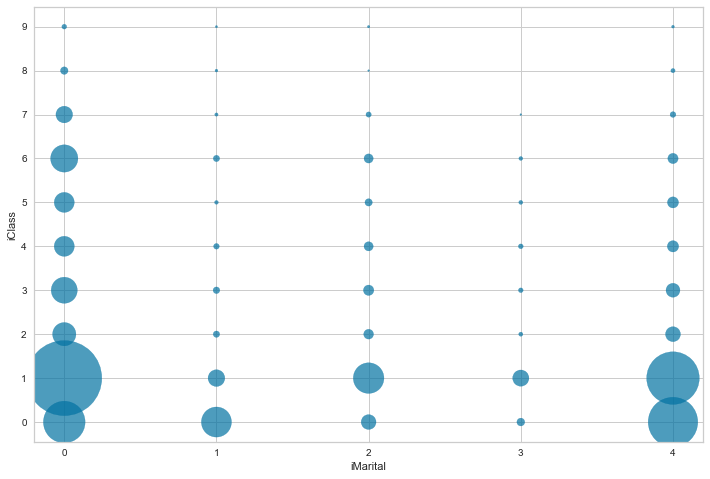

In [18]:
BubblePlot('iMarital', 'iClass')

Legenda:

|   | iMarital (marital status)          | iClass (class of worker)                          |
|---|------------------------------------|---------------------------------------------------|
| 0 | Now Married, Except Separated      | N/a Less Than 16 Yrs. Old/unemp. Who Never Worked |
| 1 | Widowed                            | Emp. of a Private for Profit Company              |
| 2 | Divorced                           | Emp. of a Private Not for Profit                  |
| 3 | Separated                          | Local Gov. Emp. City, County, Etc.                |
| 4 | Never Married or Under 15 Yrs. Old | State Gov. Emp.                                   |
| 5 |                                    | Federal Gov. Emp.                                 |
| 6 |                                    | Self Emp. in Own Not Incorp.d Business            |
| 7 |                                    | Self Emp. in Own Incorp.d Business                |
| 8 |                                    | Working Without Pay in Family Business or Farm    |
| 9 |                                    | Unemp., Last Worked in 1984 or Earlier            |

Widać, że przeważają grupy osób, które są w związku małżeńskim (1 na osi x) nigdy nie były w sformalizowanym związku lub poniiżej 15 roku życia (4 na osi x). Dodatkowo widać, że w grupie 4 na osi x, jest dużo osób, które nigdy nie były zatrudnione lub mają mniej niż 16 lat (0 na osi y), co jest dosyć intuicyjne. Dodatkowo wśród osób zamężnych jest przewaga osób pracujących prywatnie (1 na osi y)

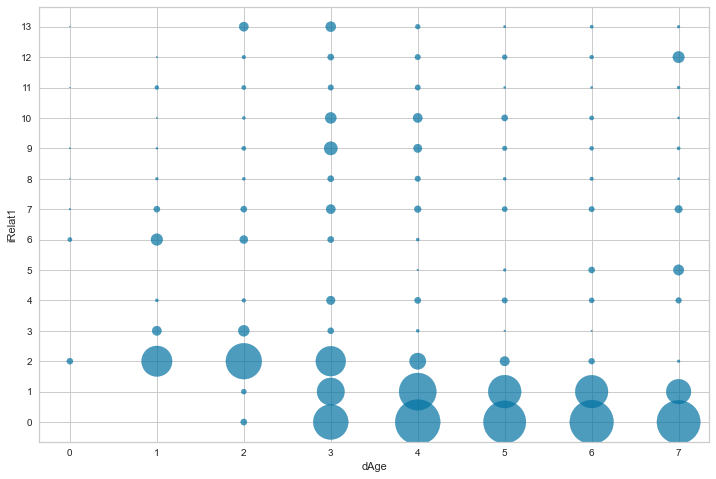

In [19]:
BubblePlot('dAge', "iRelat1")

Legenda:

|    | iRelat1 (related or not)    | dAge  |
|----|-----------------------------|-------|
| 0  | Householder                 | 0     |
| 1  | Husband/wife                | <13   |
| 2  | Son/daughter                | 13-19 |
| 3  | Stepson/stepdaughter        | 20-29 |
| 4  | Brother/sister              | 30-39 |
| 5  | Father/mother               | 40-49 |
| 6  | Grandchild                  | 50-64 |
| 7  | Other Rel.                  | >65   |
| 8  | Roomer/boarder/foster Child |       |
| 9  | Housemate/roommate          |       |
| 10 | Unmarried Partner           |       |
| 11 | Other Nonrel.               |       |
| 12 | Instit. Person              |       |
| 13 | Other Pers. in Grp. Qtrs.   |       |

Na wykresie ze zmiennymi `dAge` i `iRelat1` widać niesamowicie ciekawe i oszałamiające rzeczy. Widać, że dorosłe osoby (oznaczone numerami większymi niż 2 na osi x) są głowami rodziny (0 na osi y) i są zakawalifikowani jako mąż lub żona (1 na osi y). Natomiast osoby młodsze (1 na osi x) są kwalifikowani przede wszytskim jako dzieci, co jest spójne. 

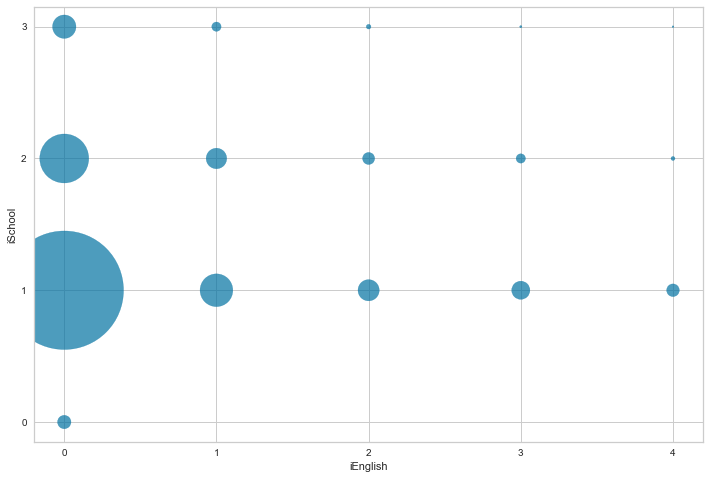

In [20]:
BubblePlot('iEnglish', 'iSchool')

Legenda: 

|    | iEnglish (ability to speak English)          | iSchool (school enrollment)        |
|----|----------------------------------------------|------------------------------------|
| 0  | N/a Less Than 5 Yrs. Old/speaks Only English | N/a Less Than 3 Yrs. Old           |
| 1  | Very well                                    | Not Attending School               |
| 2  | Well                                         | Yes, Pub. School, Pub. Coll.       |
| 3  | Not Well                                     | Yes, Private School, Private Coll. |
| 4  | Not at all                                   |                                    |

Największa grupą wśród rozważanych stanową osoby, które mówią tylko po angielsku. Wśród nich najwięcej jest osób, które nie chodzą do szkoły, czyli jak można wnioskować - dorosłych. Można też zauważyć, że więcej osób chodzi do publicznych, niż prywatnych placówek.

## Redukcja zmiennych
Postanowiliśmy bliżej przyjrzeć się zmiennymi i usunąć płeć, która wydaje się nieodpowiednia do rozważania.

In [21]:
df.drop(['iSex'], inplace = True, axis = 1)

Zauważylismy że zmienne `dIncome{1-8}` niosą te same informacje co zmienna `dRpincome`, jednak zdecydowaliśmy, że celem naszego klastwoania będzie podział na poszczególne zarobki, dlatego usuniemy te zmienne oraz bezpieśrednio powiązaną z nimi `dRearning` odpowiadającą za zarobki. 

In [22]:
df.drop(['dIncome1', 'dIncome2', 'dIncome3', 'dIncome4', 'dIncome5', 'dIncome6', 'dIncome7', 'dIncome8', 'dRpincome', 'dRearning'], inplace = True, axis = 1)

Zauważyliśmy też, że także w innym przypadku kilka kolumn niesie te same informacje, którą grupuje zmienna `iRvetserv` określona następująco:
- 00  --    N/a Less Than 16 Yrs. Old, No Active Dut
- 01  --   September 1980 or Later Only
- 02  --    May 1975 to August 1980 Only
- 03    --  May 1975 to August 1980 and September 19
- 04  --    Vietnam Era, No Korean Conflict, No Wwii
- 05  --    Vietnam Era and Korean Conflict, No Wwii
- 06  --    Vietnam Era and Korean Conflict and Wwii
- 07  --    February 1955 to July 1964 Only
- 08   --   Korean Conflict, No Vietnam Era, No Wwii
- 09  --    Korean Conflict and Wwii, No Vietnam Era
- 10  --    Wwii, No Korean Conflict, No Vietnam Era
- 11  --    Other Srvc.

Dlatego usuniemy nastepujące zmienne:

In [23]:
df.drop(['iFeb55', 'iSept80', 'iWWII', 'iKorean', 'iMay75880', 'iOthrserv', 'iVietnam'], inplace = True, axis = 1)

#### Redukcja zmiennych: korelacja Spearmana

Przejdziemy teraz do głębszej analizy zmiennych zawartych w naszej ramce. Przyjrzymy sie mapie korelacji a także zależnościom między zmiennymi. 

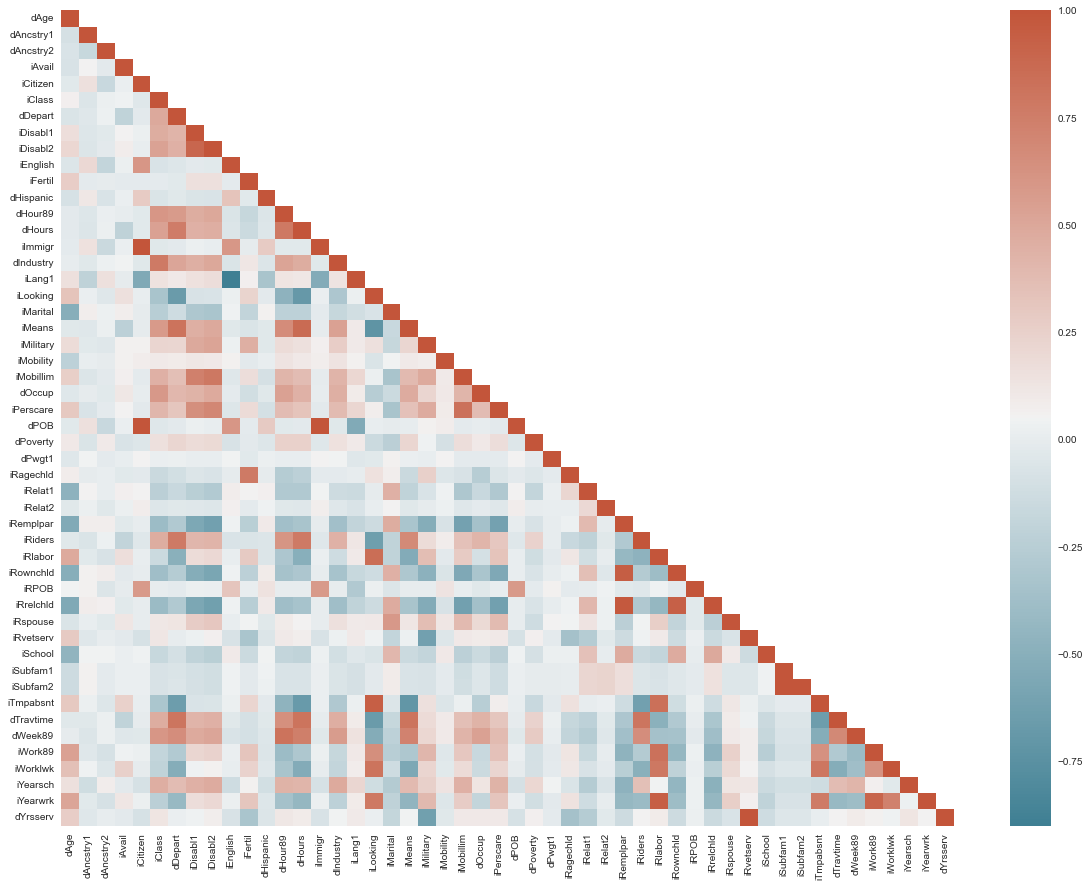

In [24]:
plt.figure(figsize=(20, 15))
dfcor = df.corr(method = 'spearman')
custom_palette = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(dfcor.where(np.tril(np.ones(dfcor.shape)).astype(np.bool_)), annot=False, cmap=custom_palette)
plt.show()

Z powyższej mapy możemy odczytać, że w ramce danych występują wysoko skorelowane zmienne. Podzbędziemy się tych o najwyższym module wartości korelacji (czyli większym od 0.75). Dla każdych 2 tak skorelowanych kolumn obliczamy średnią wartość korelacji z pozostałymi kolumnami i usuwamy tę, dla której ta średnia korelacja jest większa. 

In [25]:
corr_coeff=0.75
corr_matrix = df.corr(method = 'spearman')
corr_mean = abs(corr_matrix).mean()
features_drop_list = []
features_index_drop_list = [] 
corr_matrix = abs(corr_matrix)

for i in range(corr_matrix.shape[0]):
    for j in range(i+1,corr_matrix.shape[0]):
        if corr_matrix.iloc[i,j]>=corr_coeff and i not in features_index_drop_list and j not in features_index_drop_list:
            if corr_mean[corr_matrix.columns[i]] >= corr_mean[corr_matrix.columns[j]]:
                features_drop_list.append(corr_matrix.columns[i])
                features_index_drop_list.append(i)
            else:
                features_drop_list.append(corr_matrix.columns[j])
                features_index_drop_list.append(j)

In [26]:
print(len(features_drop_list))
print(features_drop_list)

20
['iCitizen', 'iClass', 'dHours', 'iMeans', 'dDepart', 'iDisabl2', 'iLang1', 'iFertil', 'dWeek89', 'dPOB', 'iRlabor', 'iLooking', 'iMobillim', 'iRemplpar', 'dTravtime', 'iRrelchld', 'dYrsserv', 'iSubfam1', 'iTmpabsnt', 'iYearwrk']


#### Redukcja zmiennych: algorytm MCA

In [27]:
df_mca = X.sample(frac=0.001, random_state=17)

In [28]:
df_mca_var = mca.MCA(df_mca)

Sprawdźmy najpierw do jakiej liczby zmiennych możemy zredukować:

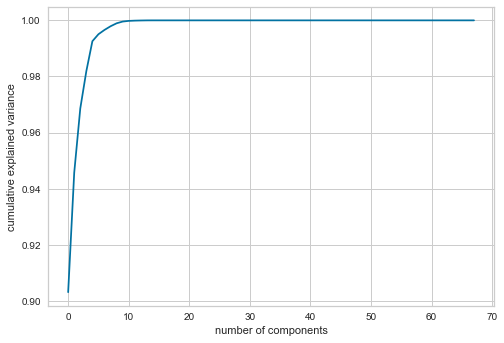

In [29]:
plt.plot(np.cumsum(df_mca_var.expl_var(greenacre=False, N=68)))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

Z wykresu wynika, że najbardziej odpowiednią wartością będzie 10.

In [30]:
mca = prince.MCA(n_components=10)
mca = mca.fit(df_mca)
mca = mca.transform(df_mca)
mca

,0,1,2,3,4,5,6,7,8,9
1043419,-0.324334,0.234473,-0.226980,0.427192,0.180220,-0.852501,0.380328,0.543162,-0.255168,0.193580
1788281,-0.358909,0.578283,-0.192518,-0.006314,-0.055363,-0.128721,-0.501309,-0.217027,0.040453,-0.123214
2007264,-0.423112,-0.285940,0.065372,0.125996,-0.114702,0.177764,0.003348,-0.028969,0.008530,0.014996
1539732,-0.460172,-0.275107,-0.295114,-0.785478,0.315357,0.030009,0.168697,-0.254292,0.134278,0.879794
1416737,-0.398745,0.661435,-0.442900,0.213640,-0.200619,0.208632,0.108523,0.002749,-0.032740,-0.065517
...,...,...,...,...,...,...,...,...,...,...
1441824,-0.386411,-0.031437,-0.244137,0.069756,0.132496,-0.545935,-0.285851,-0.019543,-0.006061,-0.086004
1677651,-0.397799,-0.372797,-0.029770,0.136698,0.292046,-0.548283,0.327822,-0.263204,-0.080387,-0.203553
7755,-0.406116,0.796810,-0.497475,0.286988,-0.284933,0.387566,0.081229,-0.091025,0.065731,0.008290
216780,2.089101,-0.089375,-0.057490,0.003596,0.062910,-0.000322,0.064284,-0.009902,-0.031288,-0.022849


#### Redukcja zmiennych: współczynnik V Craméra

In [31]:
df_cramer = X.sample(frac=0.01, random_state=17)

In [32]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

cols = df_cramer.columns.values.tolist()
corrM = np.zeros((len(cols),len(cols)))
for col1, col2 in itertools.combinations(cols, 2):
    idx1, idx2 = cols.index(col1), cols.index(col2)
    corrM[idx1, idx2] = cramers_v(df_cramer[col1], df_cramer[col2])
    corrM[idx2, idx1] = corrM[idx1, idx2]

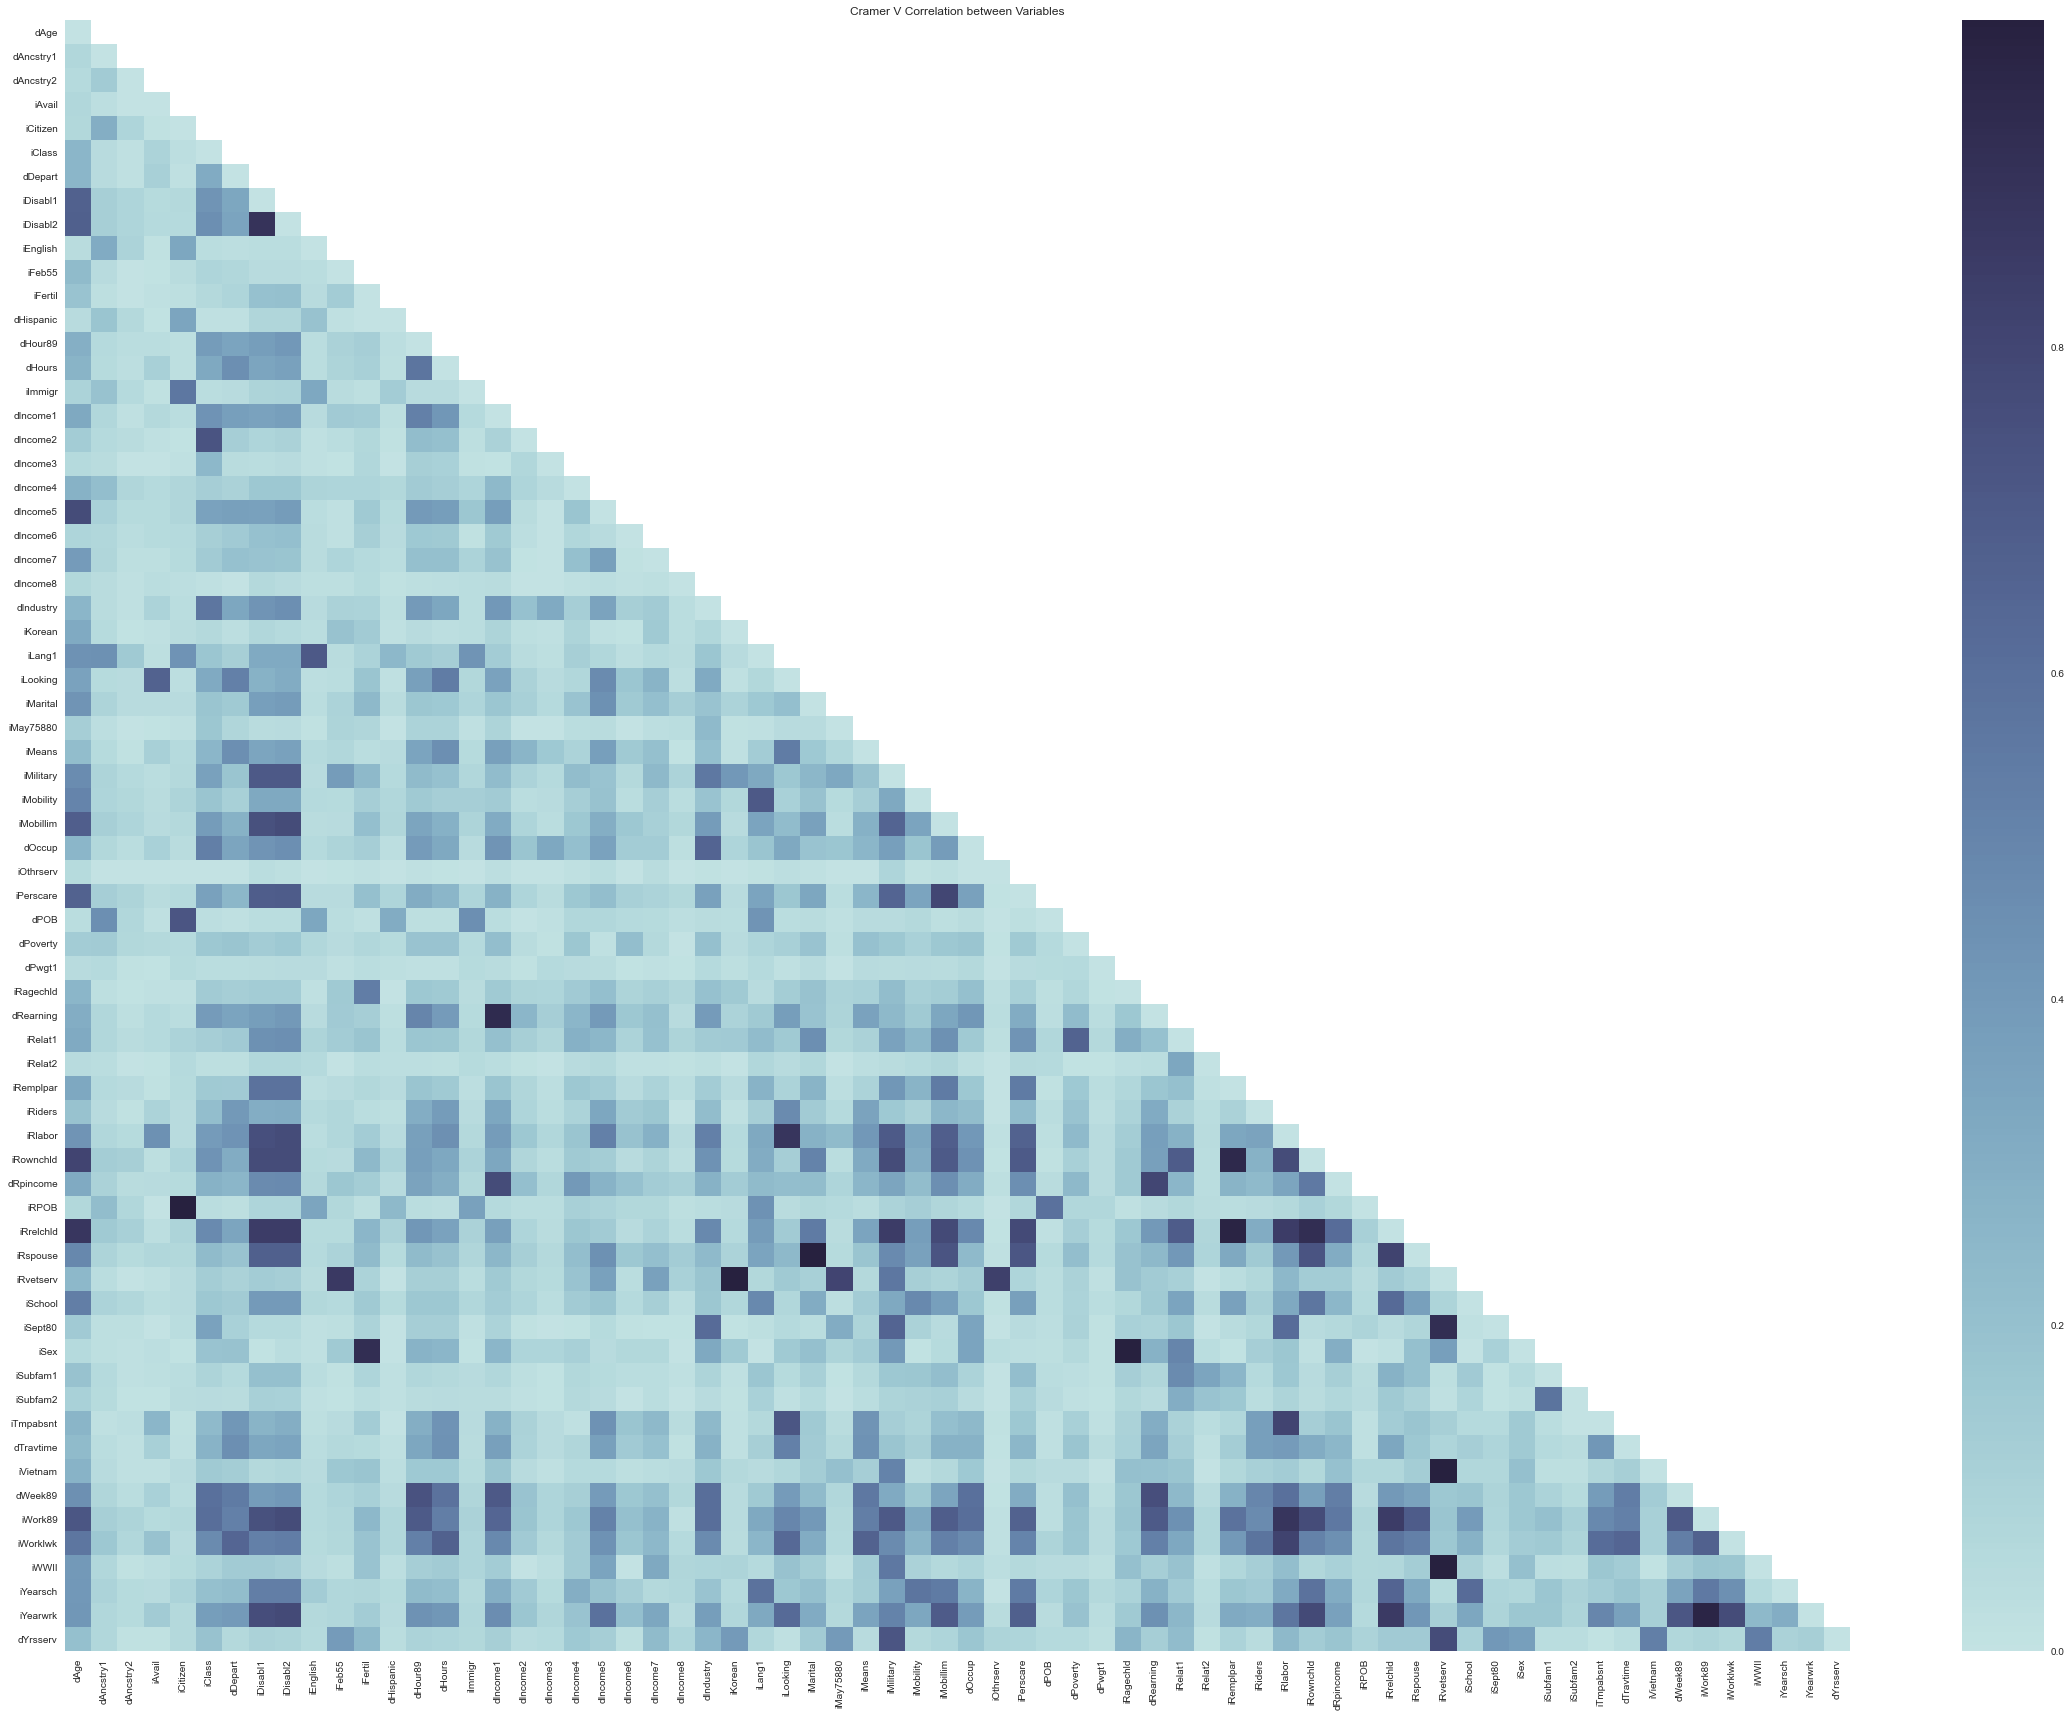

In [33]:
corr = pd.DataFrame(corrM, index=cols, columns=cols)
fig, ax = plt.subplots(figsize=(40, 30))
colors = sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True)
ax = sns.heatmap(corr.where(np.tril(np.ones(corr.shape)).astype(np.bool_)), annot=False, ax=ax, cmap = colors);
ax.set_title("Cramer V Correlation between Variables");

Kiedy współczynnik V-Cramera jest większy niż 0.6 wskazuje to na silną korelację pomiędzy zmiennymi. W tym przypadku będzimey usuwać losową spośród wysoko skorelowanych zmiennych.

In [34]:
correlated_features = set()
for i in range(len(df_cramer.columns)):
    for j in range(i):
        if abs(cramers_v(df_cramer[df_cramer.columns[i]], df_cramer[df_cramer.columns[j]])) >= 0.6:
            random = randint(0, 1)
            if random == 0:
                correlated_features.add(df_cramer.columns[i])
            else:
                correlated_features.add(df_cramer.columns[j])
print(len(correlated_features))
print(correlated_features)

42
{'iSept80', 'iRPOB', 'iRlabor', 'dRearning', 'iEnglish', 'iAvail', 'iFertil', 'dPOB', 'iTmpabsnt', 'iRspouse', 'iYearsch', 'dDepart', 'iClass', 'dYrsserv', 'iDisabl2', 'dOccup', 'iRelat1', 'iRagechld', 'iFeb55', 'iDisabl1', 'dRpincome', 'dIncome2', 'iMilitary', 'iMobillim', 'dWeek89', 'iWork89', 'iVietnam', 'iRemplpar', 'iOthrserv', 'iMobility', 'iPerscare', 'iRrelchld', 'iRvetserv', 'iWWII', 'dIncome1', 'iRownchld', 'dAge', 'dHours', 'dIndustry', 'iMarital', 'iWorklwk', 'iYearwrk'}


dla porównania usunięte przy corr Spearmana:
{'iCitizen', 'iClass', 'dHours', 'iMeans', 'iRiders', 'dTravtime', 'iDisabl2', 'iLang1', 'iFertil', 'dHour89', 'dPOB', 'dRearning', 'dIncome1', 'iRlabor', 'iLooking', 'iMobillim', 'iRagechld', 'iRemplpar', 'iRrelchld', 'dYrsserv', 'iSubfam1', 'iTmpabsnt', 'iYearwrk'}

---
---
---
## Redukcja zmiennych

Zdecydowaliśmy się na redukcję zmiennych wykonanej przy użyciu korelacji Spearmana, ponieważ MCA będzie trudne w interpretowalności, a współczynnik V-Cramera określaja poziom zależności pomiędzy dwiema zmiennymi nominalnymi, spośród których co najmniej jedna przyjmuje więcej niż dwie wartości. W naszym przypadku nie wszytskie kolumny przyjmują więcej niż 2 wartości.

In [35]:
df.drop(labels=features_drop_list, axis=1, inplace=True)
df.shape

(19985, 30)

Po obróbce zostało 30 kolumn w ramce. Jako, że wszystkie z nich są kategoryczne, zbadamy teraz ich rozkłady na grupowym histogramie.

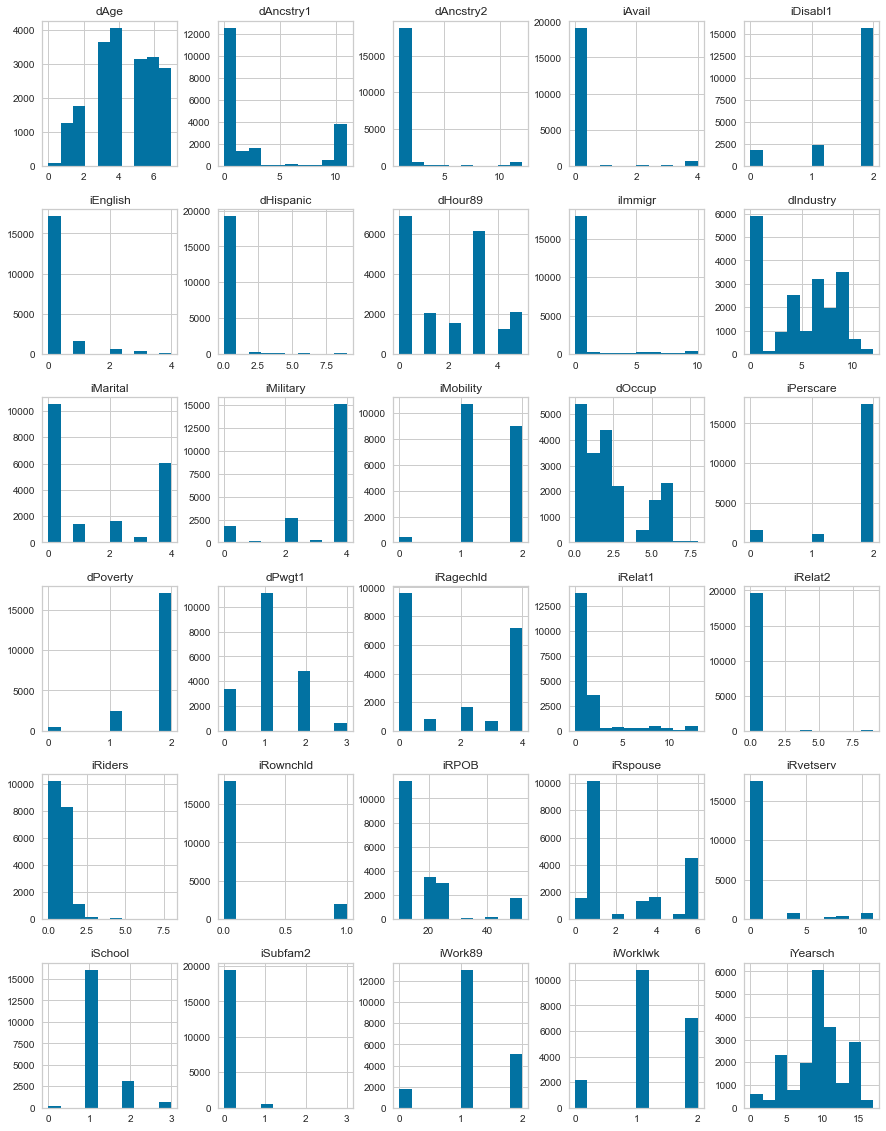

In [36]:
df.hist(figsize=(15,20))
plt.show()

Możemy zauważyć, że większość zmiennych ma bardzo nierównomierny rozkład, w którym przeważa jedna lub dwie wartości. 

### Skalowanie

W naszej ramce, również po redukcji zmiennych, znajduje się wiele kolumn, które nie wyrażają żadnego naturalnego porządku, np. kolumna `iMarital`, która mówi o stanie cywilnym danej osoby - nie da się ustawić ich w jednoznacznym porządku. Dlatego tego typu kolumny zakodujemy korzystając z częstości ich wystąpienia. Każdej wartości w kolumnie przyporządkujemy liczność tej wartości w próbce.  

In [37]:
features_to_scale = ['iAvail', 'iDisabl1', 'iMarital', 'iMilitary', 'iRelat1', 'iRPOB', 'iRspouse', 'iRelat2', 'iSchool']

In [38]:
for name in features_to_scale:
    tmp = pd.DataFrame(df[name].value_counts())
    dct = dict(pd.Series(tmp[name], tmp.index))
    df.replace({name: dct}, inplace = True)

Następnie, aby znormalizować naszą ramkę danych, postanowiliśmy przeskalować dane, aby zawierały się tylko w zbiorze [0,1]. Zmienne nadal pozostaną dyksretne, ale będzie zdecydowanie łatwiej analizować dobierane klastry w późniejszych krokach. Dodatkowo każda ze zmienne będą zrównoważone, nie będzie kilku silnie dominujących. Mamy na uwadze to, że takie skalowanie zmieni dobór klastrów, bo odległości między punktami będą ewaluowane inaczej. 

In [39]:
for col in df.columns:
    min_max_scaler1 = MinMaxScaler()
    scaled_col1 = min_max_scaler1.fit_transform(df[col].values.reshape(-1, 1))
    df[col] = scaled_col1

## Modelowanie
Do dalszej analizy będziemy wykorzystywać zaimplementowane poniżej funkcje.

In [40]:
def CentroidsMean(labs):
    '''
    Funckja, która na podstawie wektora klastrów 
    wylicza średnie centroidów każdej zmiennej 
    w każdym klastrze. Zwraca ramkę danych.
    '''
    colnames = df.columns
    centr = pd.DataFrame(columns = colnames)
    tmp = df.assign(labs = y)
    for clust in np.sort(np.unique(labs)):
        segments = tmp[tmp.labs == clust].drop('labs', axis = 1)
        means = segments.mean().values
        centr.loc[clust]= means
    return centr

def CentroidsVar(labs):
    '''
    Funckja, która na podstawie wektora klastrów 
    wylicza wariancje centroidów każdej zmiennej 
    w każdym klastrze. Zwraca ramkę danych.
    '''
    colnames = df.columns
    centrvar = pd.DataFrame(columns = colnames)
    tmp = df.assign(labs = y)
    for clust in np.sort(np.unique(labs)):
        segments = tmp[tmp.labs == clust].drop('labs', axis = 1)
        variance = segments.var().values
        centrvar.loc[clust]= variance
    return centrvar

def CentroidsPlot(centroids):
    '''
    Funckja, która tworzy wykres centroidów 
    dla wszytskich zmiennych i klastrów na
    podstawie ramki opisującej centroidy.
    '''
    cent_df = pd.DataFrame(columns= ['cluster', 'variable', 'centroid'])
    rows = centroids.shape[0]
    clusters = [x+1 for x in range(rows)]
    for colname in centroids.columns:
        data = {'cluster' : clusters,
               'variable' : [colname for x in range(rows)],
               'centroid' : centroids[colname]}
        cent_df = pd.concat([cent_df, pd.DataFrame(data)])
    plt.figure(figsize=(18, 8))
    scatter = plt.scatter(cent_df.variable, cent_df.centroid, c=cent_df.cluster, cmap='viridis', s = 200, alpha = 0.7)
    plt.legend(handles=scatter.legend_elements()[0], 
           labels=clusters,
           title="cluster")
    plt.xticks(rotation = 90, fontsize = 15)
    
def IncomeComparison(labs):
    tmp = df.assign(labs = labs)
    tmp = tmp.assign(dRpincome = dRpincome)
    tmp = tmp.groupby('labs')['dRpincome'].value_counts(normalize=True).unstack('dRpincome').replace(np.nan, 0)
    tmp.plot.barh(stacked=True, figsize = (18, 1.2*len(np.unique(labs))))
    plt.show()
    
def VarDistribution(labs, colname):
    tmp = df.assign(labs = labs)
    n = len(np.unique(tmp[colname]))
    plt.figure(figsize=(1.5*n, 8))
    tmp = tmp.groupby([colname, 'labs']).size().reset_index(name='counts')
    g = sns.barplot(x=colname, y="counts", hue="labs", data=tmp, ci=None, palette=["#9840f5", "#3185ce", "#f6ff3e"]);
    g.set_yscale('log')
    g.set_xticklabels(rotation=90, horizontalalignment='right', labels=g.get_xticklabels())
    plt.show()


#### Metoda łokcia

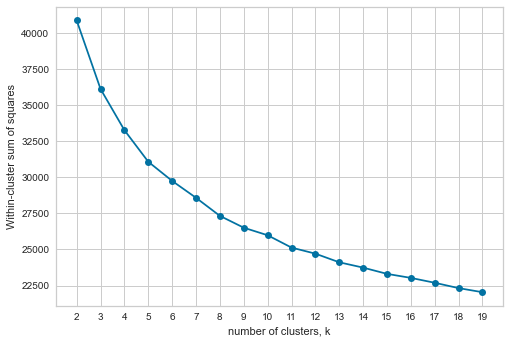

In [41]:
clus_num = range(2, 20)
scores = []

for k in clus_num:
    model = KMeans(n_clusters = k)
    model.fit(df)
    scores.append(model.score(df) * -1)
    
plt.plot(clus_num, scores, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('Within-cluster sum of squares')
plt.xticks(clus_num)
plt.show()

Na początek zbadaliśmy metodą łokcia, jaka liczba klastrów będzie optymalna. Wykres scorów dla liczby klastrów od 2 do 20 jest słabo stromy, więc trudno wybrać jednoznacznie punkt przegięcie. Ustalmy jednak, ze znajduje się on w okolicach wartośći od 5 do 9
#### Metoda Silhouette

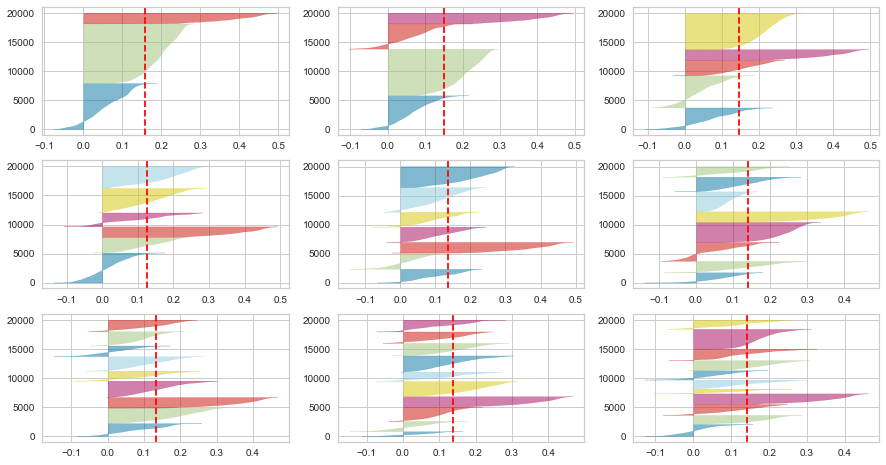

In [42]:
fig, ax = plt.subplots(3, 3, figsize=(15,8))
for i in range(3, 12):
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 3)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(df)

***
***

Uznaliśmy, ze dobrą metodą na wizualizacje jak model dzieli dane na klastry, jest wykorzystanie centroidów i porównywanie ich w zależności od klastra dla każdej ze zmiennych. Przebadamy także liczność klastrów, aby od razu zobaczyć czy na podstawie naszych klastrów da się wywnioskować przychód.

### KMeans
Na początek zbudujemy modele KMeans dla znalezionych wcześniej optymalnych liczb klastrów

In [43]:
model = KMeans(n_clusters = 5)
model.fit(df)
labs = model.labels_
centroids = model.cluster_centers_
centroids = pd.DataFrame(columns = df.columns, data = centroids)

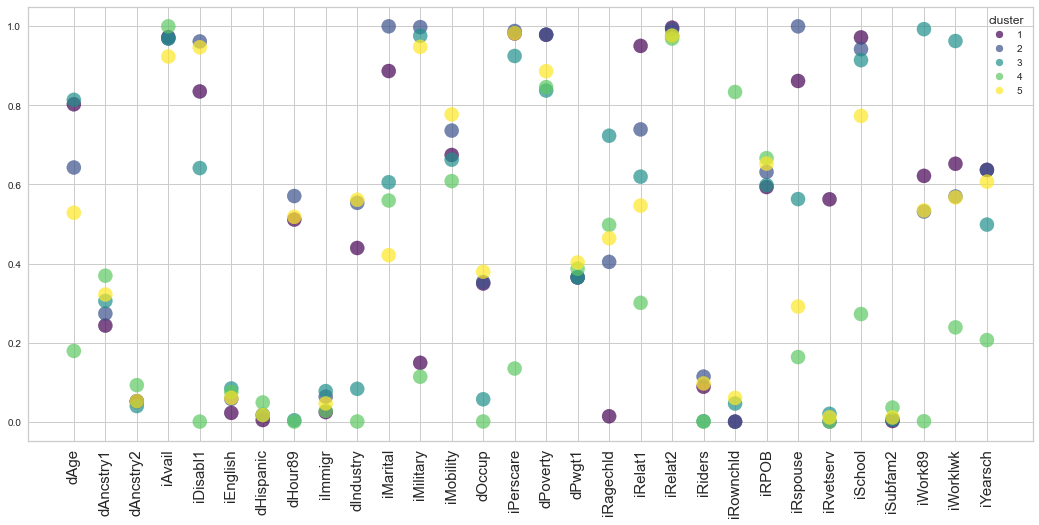

In [44]:
CentroidsPlot(centroids)

In [45]:
pd.DataFrame(labs).value_counts()

1    6263
4    5522
2    3711
0    2659
3    1830
dtype: int64

W tym momencie wyjaśnimy co oznaczają poszczególne wartości `dRpincome` - total person income signed: 

|  dRpincome  |   - total person income signed              |
|-----------------------------------------|-----------------|
| 0                                       | 0$\$$              |
| 1                                       | < 0$\$$            |
| 2                                       | 0$\$$ - 15000$\$$     |
| 3                                       | 15000$\$$ - 30000$\$$ |
| 4                                       | 30000$\$$ - 60000$\$$ |
| 5                                       | > 60000$\$$       |

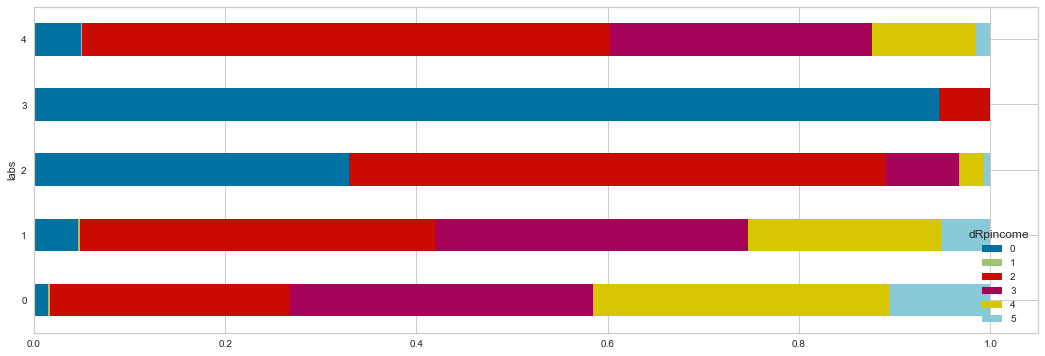

In [46]:
IncomeComparison(labs)

In [47]:
model = KMeans(n_clusters = 7)
model.fit(df)
labs = model.labels_
centroids = model.cluster_centers_
centroids = pd.DataFrame(columns = df.columns, data = centroids)

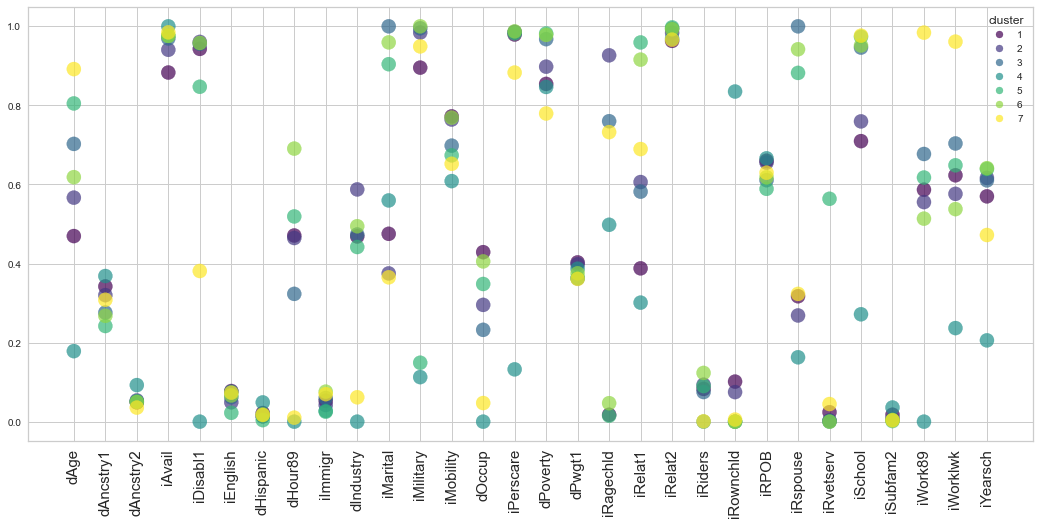

In [48]:
CentroidsPlot(centroids)

In [49]:
pd.DataFrame(labs).value_counts()

2    4384
5    3474
1    2914
0    2703
4    2583
6    2102
3    1825
dtype: int64

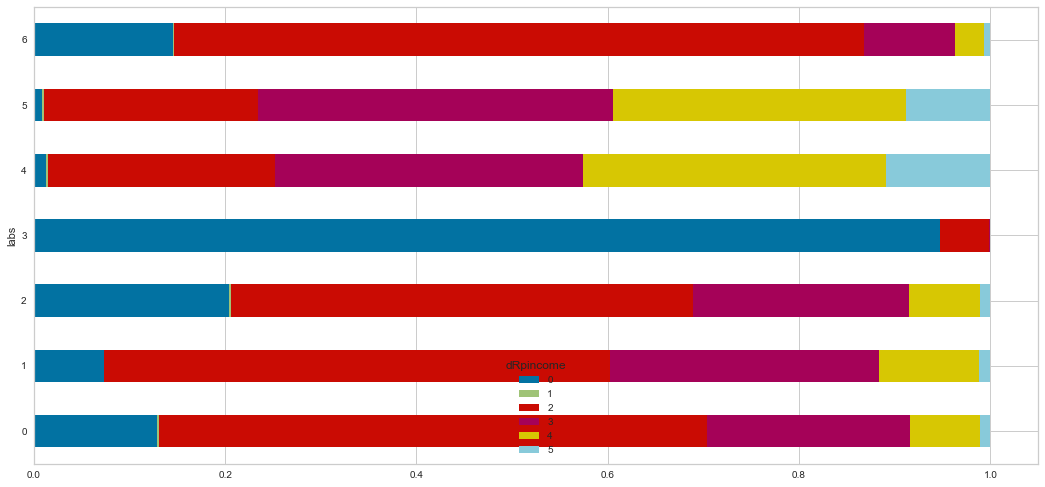

In [50]:
IncomeComparison(labs)

In [51]:
model = KMeans(n_clusters = 3)
model.fit(df)
labs = model.labels_
centroids = model.cluster_centers_
centroids = pd.DataFrame(columns = df.columns, data = centroids)

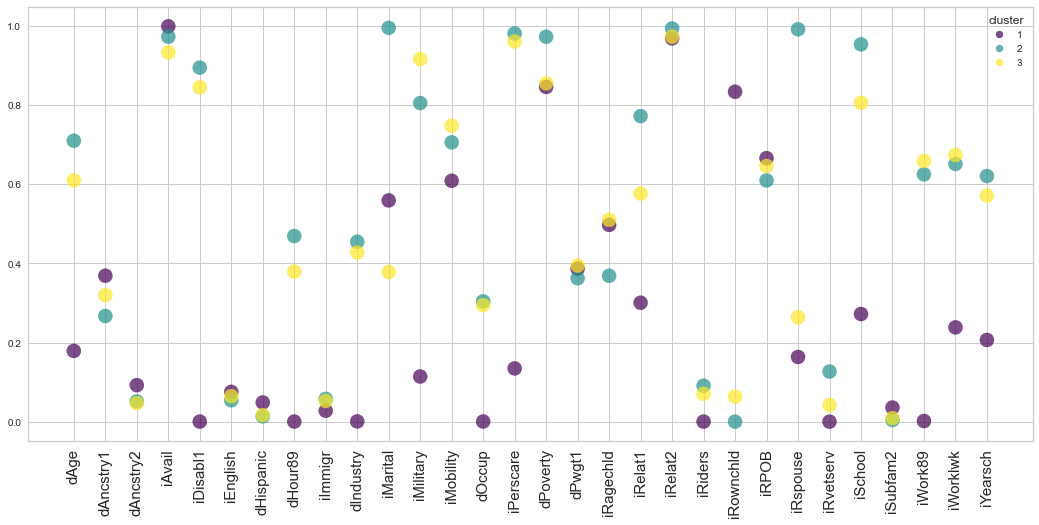

In [52]:
CentroidsPlot(centroids)

In [53]:
pd.DataFrame(labs).value_counts()

1    10246
2     7908
0     1831
dtype: int64

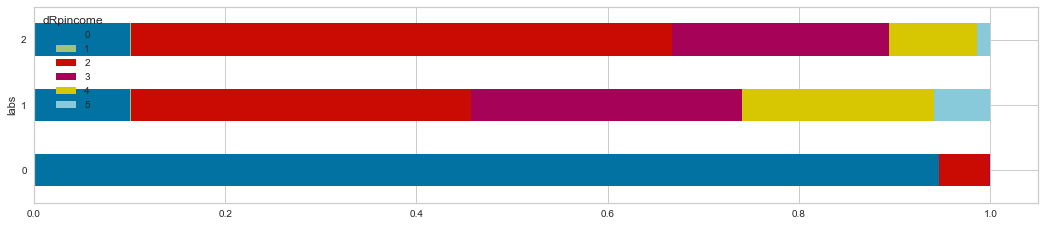

In [54]:
IncomeComparison(labs)

Widać, że dobór większej liczby klastrów sprawia problemy, ponieważ kolejne klastry są do siebie za bardzo zbliżone. Dla 5 klastrów widać, że grupy mają różne dobrane centroidy, przez co wydaje się, że rzeczywiście dobrze rozdzielają rekory na różne klastry. Jednak wydaje się, że klastry 0, 2 i 3 mają podobne rozłożenie zarobków. Najbardziej wyróżnia się we wszytskich modelach klaster w którym przeważa grupa osób o dRpincome na poziome 0, czyli faktycznie bez przychodu. Prawdopodobnie są to dzieci. Ogólnie dla KMeans dystrybucja osób w klastrach jest zrównoważona.

### Klasteryzacja hierarchiczna 

Teraz sprawdzimy jak na naszym zbiorze poradzi sobie metoda algomeracyjna klasteryzacji z wykorzystaniem progu odległości.

In [55]:
Z = hierarchy.linkage(df, method='ward')

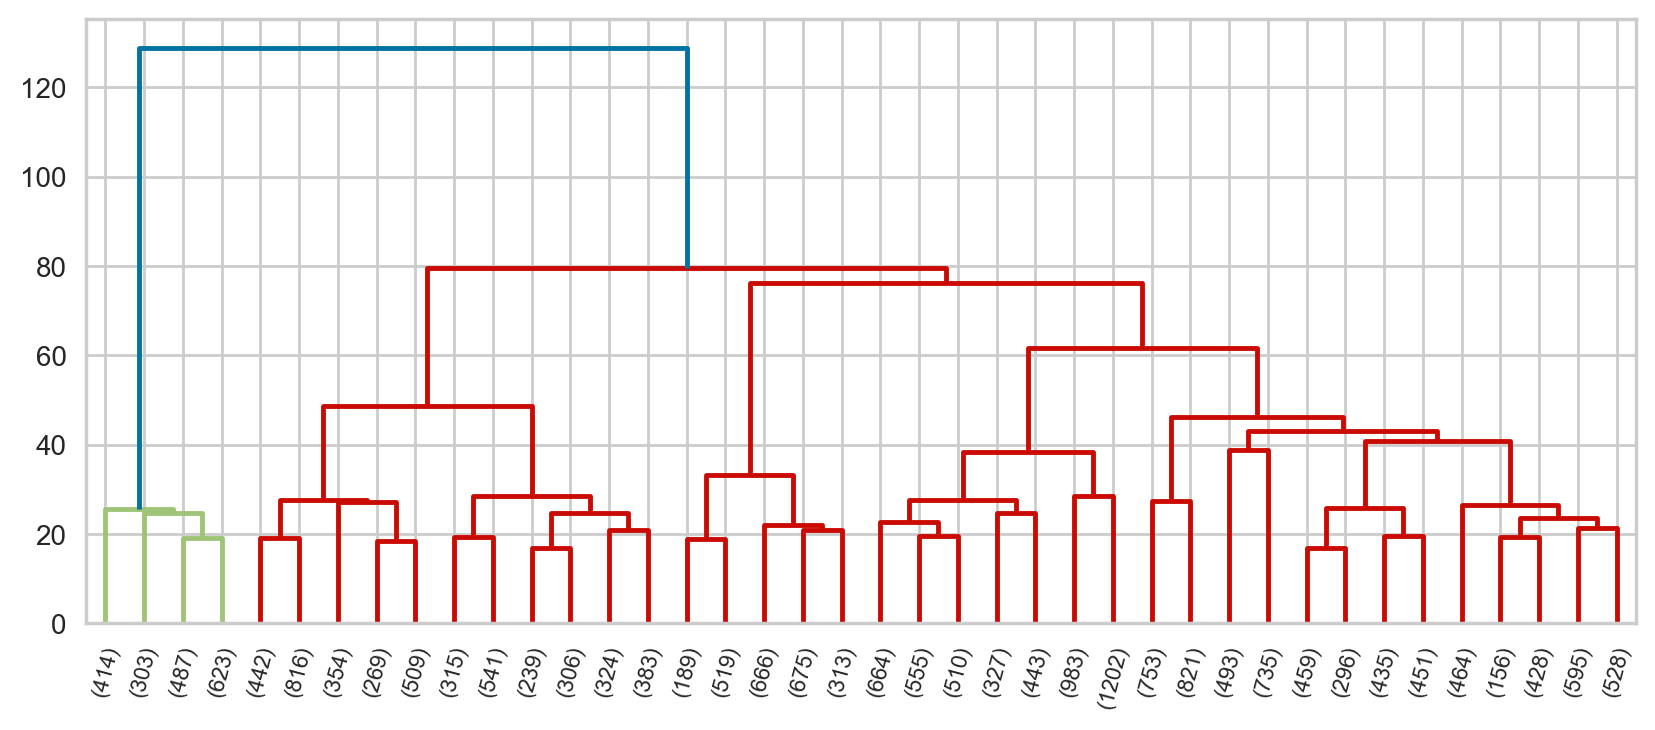

In [56]:
plt.figure(figsize=(10, 4), dpi= 200, facecolor='w', edgecolor='k')
hierarchy.dendrogram(Z, p=40, truncate_mode='lastp', leaf_rotation=75)
plt.show()

Z dendogramu można wywnioskować, że najlepsza liczba klastrów dla metody aglomeracyjnej to 3 lub 4. 

In [57]:
model = AgglomerativeClustering(n_clusters=3, linkage='ward')
y = model.fit_predict(df)

In [58]:
centroids = CentroidsMean(y)

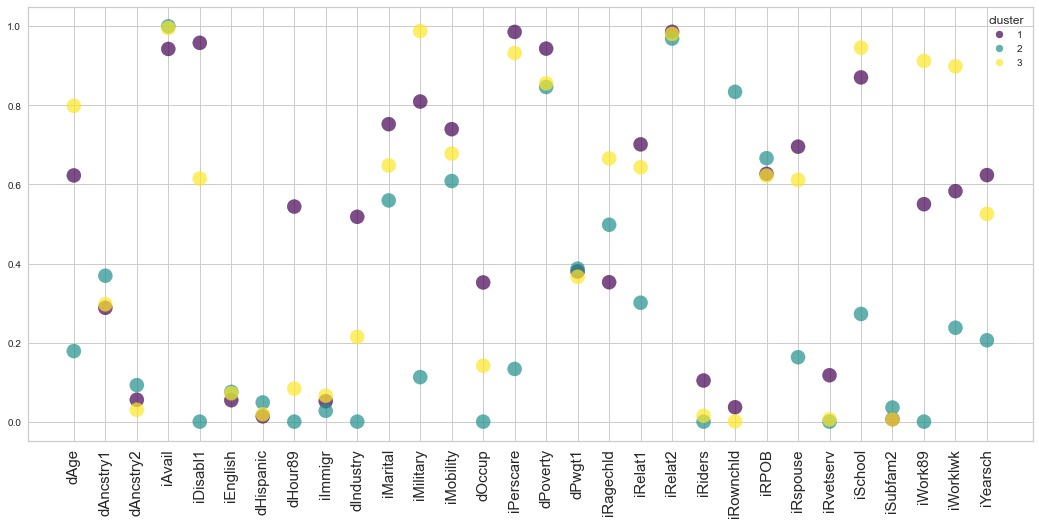

In [59]:
CentroidsPlot(centroids)

In [60]:
pd.DataFrame(y).value_counts()

0    13660
2     4498
1     1827
dtype: int64

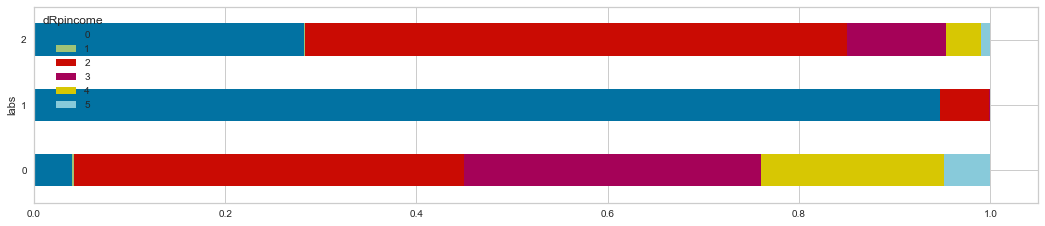

In [61]:
IncomeComparison(y)

In [62]:
model = AgglomerativeClustering(n_clusters=4, linkage='ward')
y = model.fit_predict(df)

In [63]:
centroids = CentroidsMean(y)

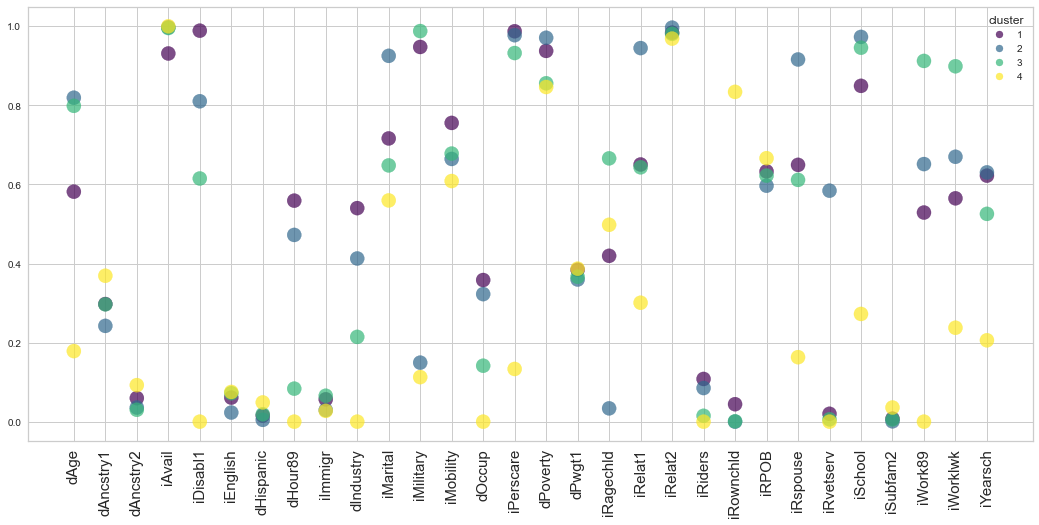

In [64]:
CentroidsPlot(centroids)

In [65]:
pd.DataFrame(y).value_counts()

0    11298
2     4498
1     2362
3     1827
dtype: int64

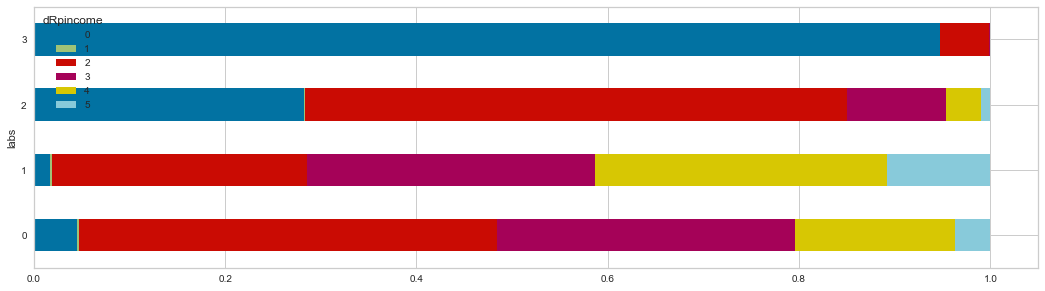

In [66]:
IncomeComparison(y)

In [67]:
model = AgglomerativeClustering(n_clusters=5, linkage='ward')
y = model.fit_predict(df)

In [68]:
centroids = CentroidsMean(y)

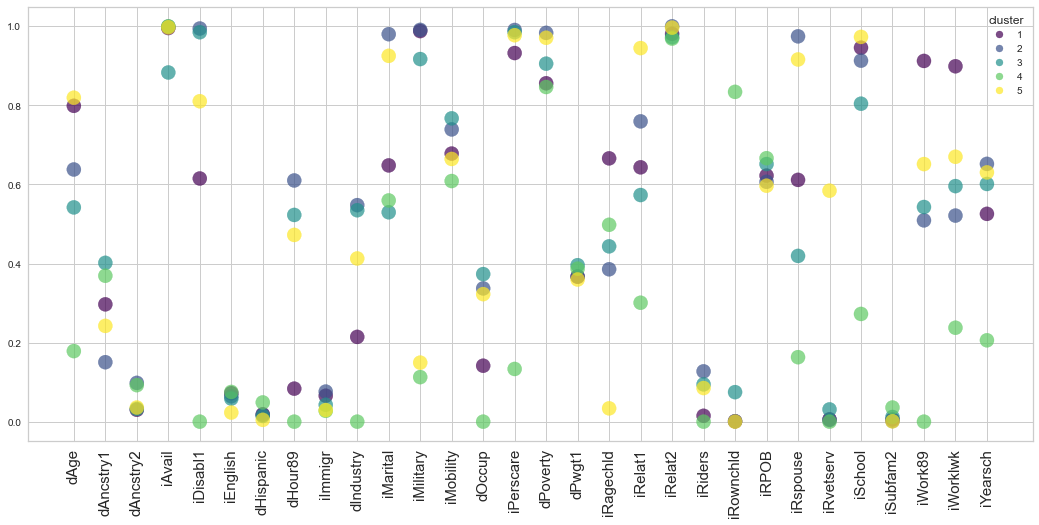

In [69]:
CentroidsPlot(centroids)

In [70]:
pd.DataFrame(y).value_counts()

2    6614
1    4684
0    4498
4    2362
3    1827
dtype: int64

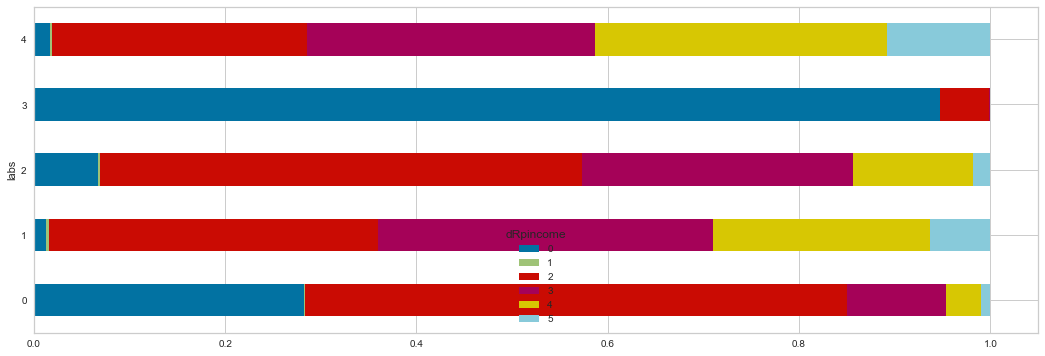

In [71]:
IncomeComparison(y)

Analizując wykresy centroidów, można dojść do wniosku, że metoda aglomeracyjna także dobrze dzieli klastry. Porównując wyniki, dla 3 klastrów widać, że 4 grupa jest potrzebna bo w zbiorze występują jeszcze rozbieżności, natomiast w przypadku 5 klastrów można zauważyć, że niekóre z nich zaczynają być zbyt zbliżone. Z kolei porownując jak klastry dopasowują się do przychodów, widać ze ta metoda radzi sobie lepiej, jako że widać pewne poziomy zarobków, w które układają się poszczególne segementy. Najbardziej intuicyjny wydaje się rozkład przychodów dla 3 klastrów.

### DBSCAN

Sprawdzimy jeszcze jak z problemem klasteryzacji w tym przypadku poradzi sobie algorytm DBSCAN. Na początek znajdziemy optymalną wartość parametru epsilon.

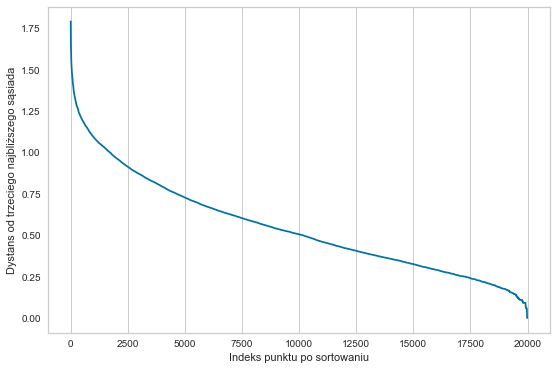

In [72]:
minPts = 5
nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors=minPts).fit(df)
distances, indices = nbrs.kneighbors(df)
distanceDec = sorted(distances[:,minPts-1], reverse=True)
fig = plt.figure(figsize=(9,6))
ax1 = fig.add_subplot(111)

plt.xlabel('Indeks punktu po sortowaniu')
plt.ylabel('Dystans od trzeciego najbliższego sąsiada')
ax1.plot(list(range(1,df.shape[0]+1)), distanceDec)

#plt.xscale('log')

plt.grid(axis='y')

plt.show()

Wykres nie daje jednoznacznych wyników. Można się spodziewać, że epsilon na poziomie 0.5-1.5 będzie odpowiedni.

In [73]:
eps = 1
dbs = cluster.DBSCAN(eps=eps, min_samples=minPts)
dbs.fit(df)

DBSCAN(eps=1)

In [74]:
y = dbs.labels_
np.sort(pd.unique(y))

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12],
      dtype=int64)

Dla epsilona równego 1 algorytm utworzył 14 klastrów. Można stwierdzić, że to za dużo. 

In [75]:
eps = 1.075
dbs = cluster.DBSCAN(eps=eps, min_samples=minPts)
dbs.fit(df)

DBSCAN(eps=1.075)

In [76]:
y = dbs.labels_
np.sort(pd.unique(y))

array([-1,  0,  1], dtype=int64)

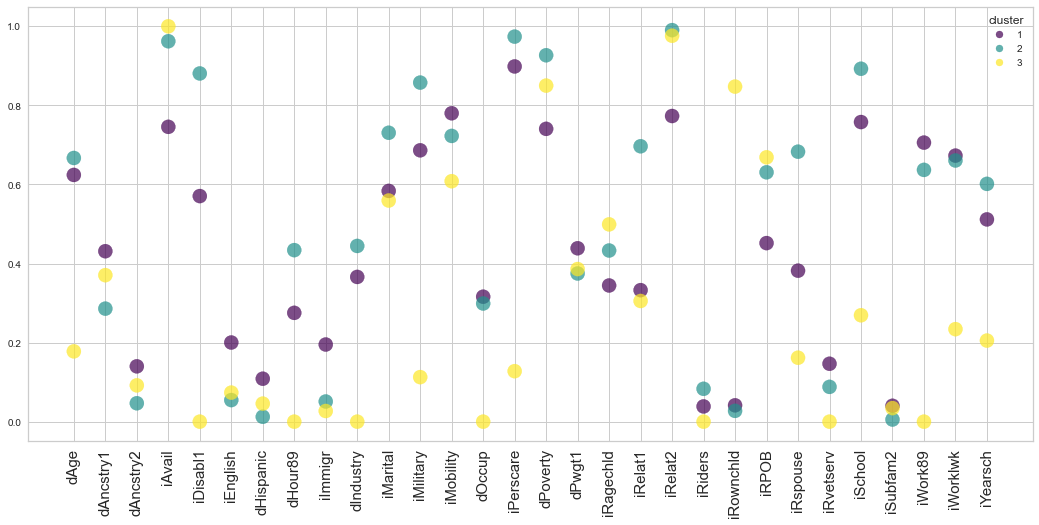

In [77]:
centroids = CentroidsMean(y)
CentroidsPlot(centroids)

In [78]:
pd.DataFrame(y).value_counts()

 0    17656
 1     1797
-1      532
dtype: int64

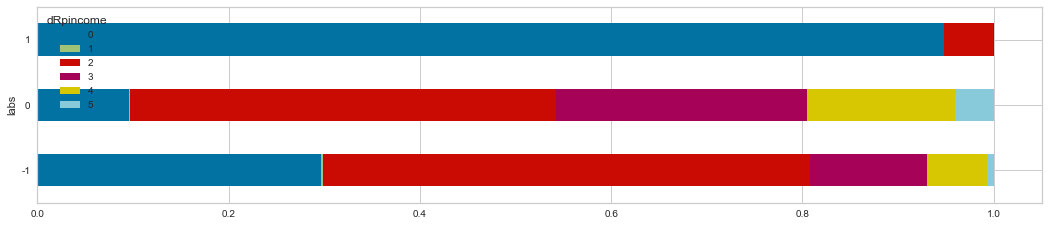

In [79]:
IncomeComparison(y)

Metodą prób i błędów udało się znaleźć najoptymalniejszy podział dla episolon = 1.075. Algorytm znalazł w tym przypadku już tylko 3 klastry. Ponownie można dojść do wniosku, że segmenty dzielą obywatelów na osoby nie zarabiające, zarabiające mniej i zarabiające więce. Jednak DBSCAN ma zbyt zbliżone proprocje między poziomami zarobków dla klastra -1 i 0. Dodatkowo segementy są mniej zrównoważone jeśli chodzi o ilość.

#### Wybór najlepszego modelu

Naszym zdaniem najlepszy jest **model aglomeracyjny** o **3 klastrach**, ponieważ wydaje się, że dobrze roździela zbiór na grupy o zróżnicowanych poziomach zarobków.

### Analiza klastrów

Teraz przejdziemy do charakteryzacji klastrów, które utworzył nasz najlepszy model.

In [80]:
model = AgglomerativeClustering(n_clusters=3, linkage='ward')
y = model.fit_predict(df)

In [81]:
pd.DataFrame(y).value_counts()

0    13660
2     4498
1     1827
dtype: int64

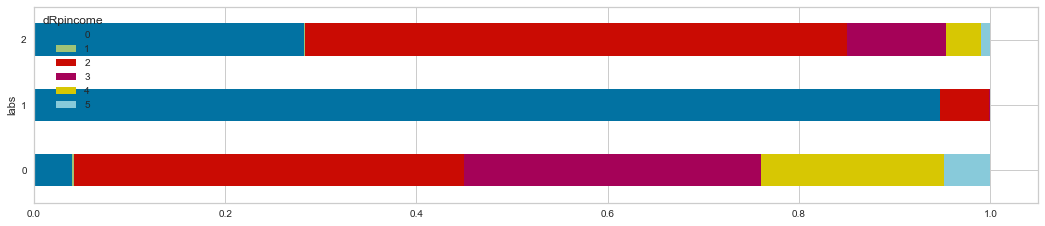

In [82]:
IncomeComparison(y)

Z analizy liczności grup, widać że przeważający jest klaster 0, w którym znalazło się 13660 osób. Są to ludzie, którzy zarabiają średnio i lepiej, co widać na wykresie. Widać, że połowa osób w tym segmencie ma przychod na poziomie 3, 4, 5, co oznacza duży przychód. Drugim licznością klastrem jest klaster nr 2, w którym z kolei przeważają osoby zarabiające mniej (poziom 2). Znalazło się też dużo osób, które nie zarabiają. Najmniej liczny jest klaster 1, w którym zdecydowanie przeważają osoby niezarabiające. Teraz spróbujemy scharakteryzować klastry używając innych zmiennych. 

In [83]:
with pd.option_context("display.max_columns", None):
    display(CentroidsMean(y))

,dAge,dAncstry1,dAncstry2,iAvail,iDisabl1,iEnglish,dHispanic,dHour89,iImmigr,dIndustry,iMarital,iMilitary,iMobility,dOccup,iPerscare,dPoverty,dPwgt1,iRagechld,iRelat1,iRelat2,iRiders,iRownchld,iRPOB,iRspouse,iRvetserv,iSchool,iSubfam2,iWork89,iWorklwk,iYearsch
0,0.622819,0.287941,0.055444,0.942738,0.958103,0.054283,0.013543,0.544041,0.051837,0.518125,0.752531,0.809699,0.739861,0.352068,0.985761,0.943521,0.379893,0.352709,0.701415,0.986051,0.104017,0.036530,0.626732,0.695604,0.117456,0.870782,0.006369,0.550146,0.583089,0.623689
1,0.178513,0.369060,0.092402,1.000000,0.000000,0.075123,0.048653,0.000000,0.027313,0.000000,0.559599,0.112699,0.608648,0.000000,0.133279,0.846470,0.386973,0.497947,0.300776,0.968888,0.000000,0.834154,0.666453,0.163125,0.000000,0.272430,0.035760,0.000000,0.237548,0.205834
2,0.798863,0.296758,0.030054,0.995670,0.615093,0.071921,0.018576,0.083504,0.065562,0.214392,0.648176,0.987989,0.678079,0.141480,0.932414,0.855936,0.366459,0.666018,0.643351,0.980921,0.014784,0.000889,0.622360,0.611526,0.005922,0.945881,0.005706,0.912406,0.898955,0.525567


In [84]:
with pd.option_context("display.max_columns", None):
    display(CentroidsVar(y))

,dAge,dAncstry1,dAncstry2,iAvail,iDisabl1,iEnglish,dHispanic,dHour89,iImmigr,dIndustry,iMarital,iMilitary,iMobility,dOccup,iPerscare,dPoverty,dPwgt1,iRagechld,iRelat1,iRelat2,iRiders,iRownchld,iRPOB,iRspouse,iRvetserv,iSchool,iSubfam2,iWork89,iWorklwk,iYearsch
0,0.040079,0.128131,0.027698,0.052373,0.038412,0.026695,0.008205,0.085355,0.031572,0.054965,0.108716,1.272443e-01,0.062402,0.056563,0.006917,0.034569,0.055556,0.190481,0.117115,0.013723,0.009376,0.035198,0.184209,0.134129,0.071172,0.093118,0.002327,0.022560,0.055106,0.025777
1,0.005277,0.143503,0.052101,0.000000,0.000000,0.032723,0.031166,0.000000,0.008525,0.000000,0.000106,1.769145e-29,0.150703,0.000000,0.114346,0.066640,0.071844,0.249825,0.025896,0.030074,0.000000,0.138417,0.182984,0.010400,0.000000,0.103286,0.011742,0.000000,0.174099,0.013080
2,0.047208,0.137048,0.009383,0.004200,0.220885,0.038550,0.013585,0.043513,0.047613,0.090413,0.167199,1.002304e-02,0.057340,0.050405,0.029231,0.071525,0.056595,0.181029,0.115813,0.018679,0.003249,0.000889,0.184170,0.175243,0.003591,0.042862,0.001870,0.036132,0.065116,0.033890


Na tabelkach powyżej widać średnie i wariancje każdej kolumny dla poszczególnych klastrów. Widać, że są kolumny, których średnie wartości są bardzo zróżnicowane. Przykłady takich kolumn to `dAge` lub `iSchool`. Ważna jest także wariancja dla klastrów. Można zaobserwować, że dla większości kolumn i klastrów nie przekracza ona 0.1, co oznacza że wartości są dosyć mało rozproszone w większości przypadków. Jednak dla zmiennej `iRagechld` dla przykładu, wariancja dla klastra 2 przekracza 0.2. Może to oznaczać, że w różnych klastrach znajdują się bardzo rozproszone wartości, a co za tym idzie, zmienna ta niekoniecznie dobrze charakteryzuje segmenty. Teraz przedstawimy jeszcze raz centroidy na wykresie.

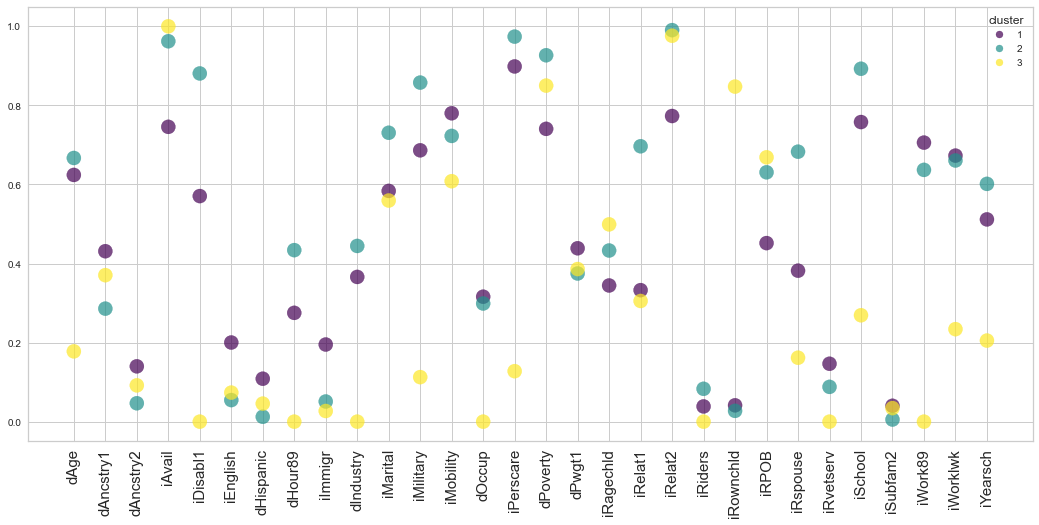

In [85]:
CentroidsPlot(centroids)

Możemy dzięki temu wizaulnie ocenić, które zmienne faktycznie dobrze różnicują segemnty. Widać, że takimi zmiennymi mogą być `dAge`, `iDisabl1`, `dIndustry`, `iMilitary`, `iRSpouse`, `iWork89` i `iYearsch`. 

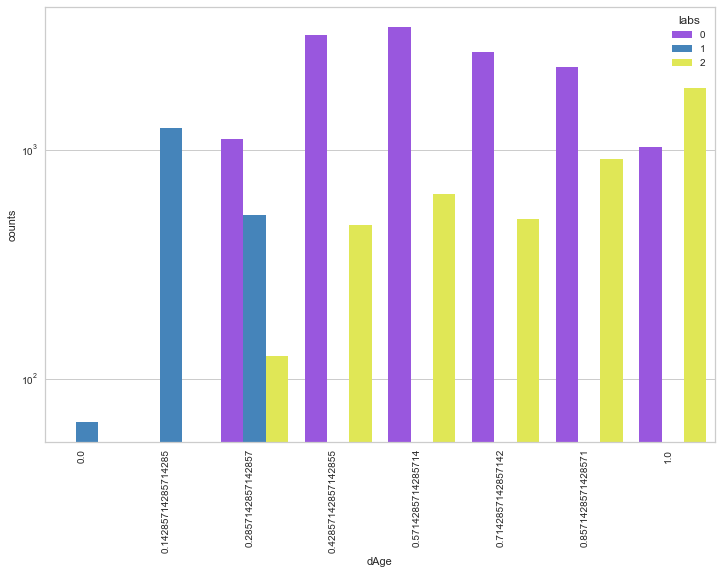

In [86]:
VarDistribution(y, 'dAge')

Mając na uwadze to, że wiek rośnie wraz ze wzrostem wartości zmiennej `dAge`, można zauważyć, że w klastrze którym najwięcej osob nie zarabiało, to głównie dzieci i młodzież. Widać, że w klastrze zarabiających najlepiej jest dużo osób w średnim wieku, natomiast w klastrze osób zarabiających mniej z wiekiem wzrasta obecność obywateli w tym klastrze. 

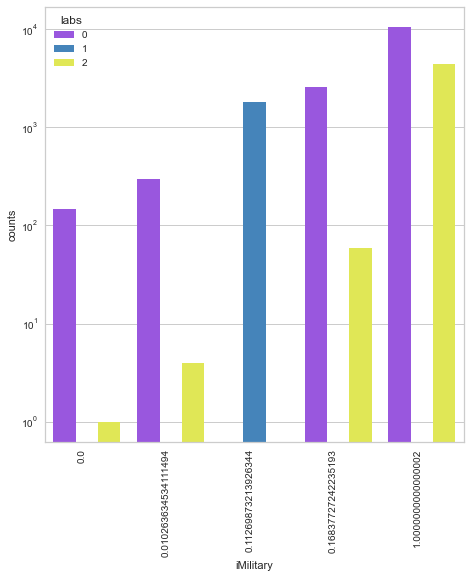

In [87]:
VarDistribution(y, 'iMilitary')

In [88]:
tmp = pd.DataFrame(df2['iMilitary'].value_counts())
tmp

,iMilitary
4,15054
2,2657
0,1827
3,300
1,147


* 0  ---     N/a Less Than 16 Yrs. Old
* 1  ---     Yes, Now on Active Duty
* 2  ---     Yes, on Active Duty in Past, But Not Now
* 3  ---     Yes, Srvc. in Reserves or Nat. Guard Onl
* 4  ---     No Srvc.

Jako, że `iMilitary` jest zmienną, którą zakodowaliśmy po częstościach, powyżej odkodowujemy kolejność (kolejność na wykresie jest taka jak wzrastająca kolejność częstości). Poraz kolejny widać, że klaster nierabiających to dzieci, bo środkowa wartość odpowiada w tej kolumnie za osoby poniżej 16 roku życia. Uwzględniając skalę logarytmiczną na osi y, można też stwierdzić, że w klastrze osób zarabiających lepiej jest proporcjonalnie więcej osób pełniących służbę. 

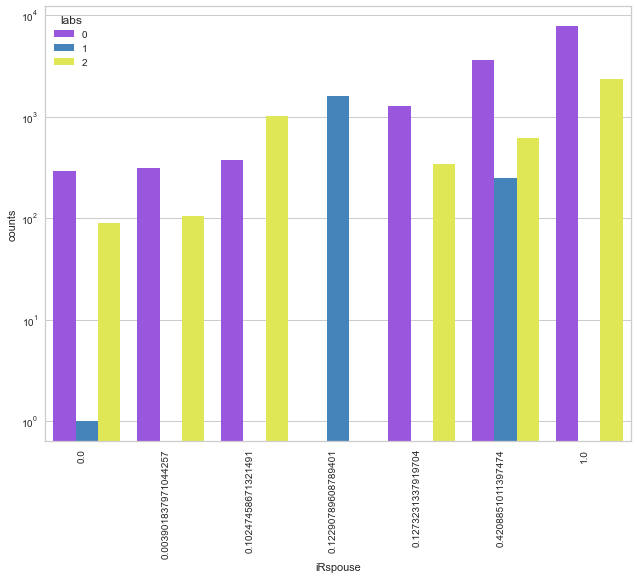

In [89]:
VarDistribution(y, 'iRspouse')

In [90]:
tmp = pd.DataFrame(df2['iRspouse'].value_counts())
tmp

,iRspouse
1,10121
6,4481
4,1622
0,1579
3,1380
5,420
2,382


- 0   ---    N/a Less Than 15 Yrs. Old
- 1   ---    Now Married, Spouse Present
- 2   ---    Now Married, Spouse Absent
- 3   ---    Widowed
- 4   ---    Divorced
- 5   ---    Separated
- 6   ---    Never Married

Ponownie potwierdzają się wnioski co do klastra osob nie zarabiających - przewaga dla wartości 0 (poniżej 15r życia), albo 6 (nigdy nie w związku małżeńskim). natomiast widać, że obie grupy zarabiających są do siebie bardzo zbliżone. Dosyć niestandardowy jest fakt, że w grupie zarabiających mniej jest więcej osób rozwiedzionych.

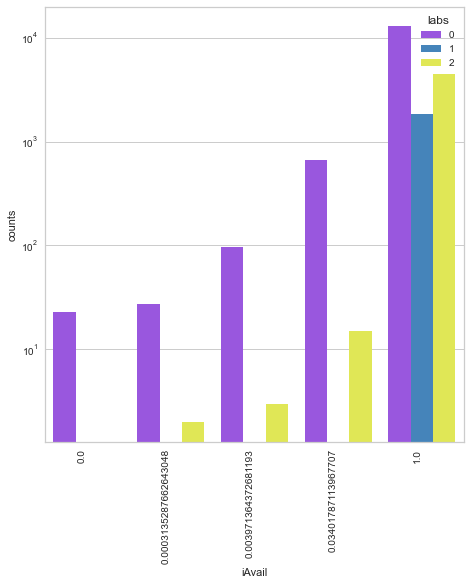

In [91]:
VarDistribution(y, 'iAvail')

In [92]:
tmp = pd.DataFrame(df2['iAvail'].value_counts())
tmp

,iAvail
0,19160
4,674
3,99
2,29
1,23



                                  0       N/a Less Than 16 Yrs./at Work/not Looking
                                  1       No, Already Has a Job
                                  2       No, Temply. Ill
                                  3       No, Other Reasons in School, Etc.
                                  4       Yes, Could Have Taken a Job

Dla zmiennej `iAvail`, która oznacza gotowość do pracy, 0 koduje informację, że osoba nie może podjąć jeszcze pracy ze względu na wiek albo nie szuka zatrudnienia albo jest zatrudniona. Jest to dość oczywiste, że właśnie w tej wartości zawiera się klaster dotyczący nie zarabiających, czyli dzieci jak to juz ustaliliśmy.  Widać natomiast, że jest duża przewaga osób zarabiających dużo w pozostałych wartociach. Kodują one głównie gotowość do pracy od razu, lub informują o powodach dla których osoba nie może podjąć pracy. 

## Podsumowanie

Dla naszego problemu poszukiwania homogenicznych grup osób ze Stanów Zjednocznych skupiliśmy na wyodrębnieniu klastrów o różnych poziomach zarobków. Udało się to przy użyciu modelu aglomeracyjnego o 3 klastrach. Każdy z klastrów ma swoje charakterystyski.
* Klaster 1; osoby bez przychodu - Głownie dzieci i młodzież, nie mogą mieć przychodu, ani żadnych relacji/związków małżeńskich.
* Klaster 2; osoby z małym przychodem - Osoby dorosłe, których dochód jest przeważająco mały/średni lub nie mają przychody. Znajdują się tu sporo osób owdowiałych, a także wyraźnie starszych, być może na emeryturze. 
* Klaster 3; osoby z dużym przychodem - Osoby dorosłe, których dochód jest przeważająco średni/duży/bardzo duży. Są to osoby w średnim wieku (20-40 lat), czynnie pracujące, często też służące w wojsku, raczej zamężne.